# Examples Graphs Figures Notebook

In [1]:
import os
import random
import pickle
import numpy as np
import pandas as pd

from glob import glob
from enum import Enum
from collections import OrderedDict

FREQUENCY = 1
COLUMNS = [0,0.01,0.02,0.04,0.08,0.16,0.32,0.64]
ROWS = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]

pickle_dir="/home/liad/dev/research/notebooks/pickles/full/"
num_iocs_df = pd.read_csv("/home/liad/dev/research/notebooks/data-vt-v22/attack_num_iocs_vt_v22.csv")

# Utilities

class ConfusionMatrix(Enum):
    RECALL = 0
    PRECISION = 1
    AVG_REWARD = 2

def pickle_to_file(file, obj, base_dir=pickle_dir, force=False):
    full_path = f"{base_dir}/{file}.pickle"
    if os.path.exists(full_path) and not force:
        print(f"{full_path} already exists. exits.")
        return
    with open(full_path, 'wb') as of:
        pickle.dump(obj, of)

def pickle_from_file(file, base_dir=pickle_dir):
    full_path = f"{base_dir}/{file}.pickle"
    with open(full_path, 'rb') as infile:
        return pickle.load(infile)

def mutiple_pickle(results_base_num, results_dir):
    ucb1rnddf = pickle_from_file(f"merged_{results_base_num + 7}", results_dir)
    rnddf = pickle_from_file(f"merged_{results_base_num + 3}", results_dir)
    saucbmsdf = pickle_from_file(f"merged_{results_base_num + 4}", results_dir)
    saeg01msdf = pickle_from_file(f"merged_{results_base_num + 0}", results_dir)
    ucb1msdf = pickle_from_file(f"merged_{results_base_num + 6}", results_dir)
    rndmsdf = pickle_from_file(f"merged_{results_base_num + 9}", results_dir)
    eg01rnddf = pickle_from_file(f"merged_{results_base_num + 2}", results_dir)
    saucbrnddf = pickle_from_file(f"merged_{results_base_num + 5}", results_dir)
    msdf = pickle_from_file(f"merged_{results_base_num + 8}", results_dir)
    eg01msdf = pickle_from_file(f"merged_{results_base_num + 1}", results_dir)
    oracledf = pickle_from_file(f"merged_{results_base_num + 10}", results_dir)
    
    ret_tuple = (ucb1rnddf, rnddf, saucbmsdf, saeg01msdf, 
                 ucb1msdf, rndmsdf, eg01rnddf, saucbrnddf, 
                 msdf, eg01msdf, oracledf)
    
    
    ret_list = list(ret_tuple)
    for idx, df in enumerate(ret_list):
        if str(df.columns.dtype) != "float64":
            ret_list[idx] = df.rename(columns={'0.0': 0.0, '0.01':0.01,  '0.02':0.02, '0.04':0.04, '0.08':0.08, '0.16':0.16, '0.32':0.32, '0.64':0.64})
        
    return tuple(ret_list)

def get_attack_num_iocs(attack_id):
    df = num_iocs_df[num_iocs_df["attack"] == int(attack_id)]
    return int(df["num_iocs"])

def get_attacks_with_num_iocs(niocs_lower_bound=0, niocs_upper_bound=50000):
    df = num_iocs_df[num_iocs_df["num_iocs"] >= niocs_lower_bound]
    df = num_iocs_df[num_iocs_df["num_iocs"] <= niocs_upper_bound]
    return list(df['attack'])

def get_attacks_in_dir(results_dir):
    attack_ids = set()
    for attack_file in glob(f"{results_dir}/cm_*_*.csv*"):
        attack_id = attack_file.split("_")[-3]
        attack_ids.add(int(attack_id))
    return attack_ids

def avg_element(x):
    if type(x) is not list:
        return round(x, 4)
    else:
        return round((sum(x) / len(x)), 4)

# Average precision
def get_mAP_matrix(results_dir, attack_id, iterations):
    i = 0
    df = pd.DataFrame(columns=COLUMNS, index=ROWS)
    attack_num_iocs = get_attack_num_iocs(attack_id)
    
    for attack_file in glob(f"{results_dir}/cm_*_{attack_id}_*_*.csv"):
        attack_file_df = pd.read_csv(attack_file)
        
        mAP = 0
        prev_cm_tp = 0
        for r in attack_file_df.iterrows():
            it = r[1]['iteration']
            fp = r[1]['ex_fp']
            fn = r[1]['ex_fn']
            cm_tp, cm_tn, cm_fp, cm_fn = r[1]['cm_tp'],r[1]['cm_tn'],r[1]['cm_fp'],r[1]['cm_fn']
        
            if (it > iterations):
                # sometimes we will ask for less iterations then available
                # thus no need to keep going
                break
            
            if (cm_tp > prev_cm_tp):
                cur_mAP = cm_tp / it
            else:
                cur_mAP = 0
            mAP += cur_mAP
            prev_cm_tp = cm_tp
        
        # if number of iterations is less then number of artifacts
        gtp = it if it < attack_num_iocs else attack_num_iocs
        mAP = (1/gtp) * mAP
        if df[fp][fn] is np.nan:
            df[fp][fn] = mAP
        elif type(df[fp][fn]) is list:
            df[fp][fn].append(mAP)
        else:
            df[fp][fn] = [df[fp][fn], mAP]
        
    df = df.applymap(avg_element)
    return df
    

def get_mAP_matrix_all(results_dir, iterations, num=251 ,attacks=[], avg=True):
    attacks_in_dir = get_attacks_in_dir(results_dir)
    
    if len(attacks) > 0:
        selected_attacks = attacks
    elif num == 251:
        selected_attacks = list(attacks_in_dir)
    else:
        attacks_with_num_iocs = random.sample(get_attacks_with_num_iocs(3000, 5000), num)
        selected_attacks = list(attacks_in_dir.intersection(set(attacks_with_num_iocs)))
    
    attack_results = []
    job_num = results_dir.split("_")[-1]
    job_dir = f"{pickle_dir}/{job_num}"
    
    if not os.path.exists(job_dir):
        os.makedirs(job_dir)
    
    for attack in selected_attacks:
        if os.path.exists(f"{job_dir}/attack_{attack}.pickle"):
            attack_mAP = pickle_from_file(f"{job_num}/attack_{attack}")
        else:
            attack_mAP = get_mAP_matrix(results_dir, attack, iterations)
            pickle_to_file(f"{job_num}/attack_{attack}", attack_mAP)
            
        attack_results.append(attack_mAP)
        print(".", end=" ")
        
    if avg:
        attack_results = pd.concat(attack_results).groupby(level=0).mean()
    print(f"Finished {results_dir}")
    

    return attack_results



In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

plt.style.use('seaborn-whitegrid')

def plot_mAP_policies(results_tuple, title="", fp=None, fn=None):
    (ucb1rnddf, rnddf, saucbmsdf, saeg01msdf, 
     ucb1msdf, rndmsdf, eg01rnddf, saucbrnddf, 
     msdf, eg01msdf, oracledf) = results_tuple
    
    if fp is None:
        func_y = lambda x: x.iloc[int(10*fn)]
        func_x = lambda x: x.columns
        arg = fn
    elif fn is None:
        func_y = lambda x: x[fp]
        func_x = lambda x: x.index
        arg = fp
        
    
    fig = plt.figure(figsize=(12,12))
        
#     plt.plot(func_x(oracledf),
#              func_y(oracledf),
#              linewidth=3, label="ORACLE", color="darkred")

    plt.plot(func_x(saeg01msdf),
             func_y(saeg01msdf),
             linewidth=3, label="SAEG01-MS", color="tab:blue")
    
    plt.plot(func_x(saucbmsdf),
            func_y(saucbmsdf),
             linewidth=3, label="SAUCB-MS", color="tab:green")

    plt.plot(func_x(eg01msdf),
            func_y(eg01msdf),
             linewidth=3, label="EG01-MS", color="tab:orange")

    plt.plot(func_x(ucb1msdf),
            func_y(ucb1msdf),
             linewidth=3, label="UCB1-MS", color="tab:red")

    plt.plot(func_x(saucbrnddf),
            func_y(saucbrnddf),
             linewidth=3, label="SAUCB-Rnd", color="tab:purple")

    plt.plot(func_x(ucb1rnddf),
            func_y(ucb1rnddf),
             linewidth=3, label="UCB1-Rnd", color="tab:pink")

    plt.plot(func_x(eg01rnddf),
            func_y(eg01rnddf),
             linewidth=3, label="EG01-Rnd", color="tab:brown")

    plt.plot(func_x(msdf),
            func_y(msdf),
             linewidth=3, label="MS", color="tab:olive")

    plt.plot(func_x(rndmsdf),
            func_y(rndmsdf),
             linewidth=3, label="Rnd-MS", color="tab:gray")

    plt.plot(func_x(rnddf),
            func_y(rnddf),
             linewidth=3, label="Rnd-Rnd", color="tab:cyan")
    
    plt.suptitle(title.format(arg), fontsize=20)
    plt.xlabel(r'$P_{f_p}$' if fp is None else r'$P_{f_n}$', fontsize=34)
    plt.ylabel('mAP', fontsize=34)
     
    fig.legend(loc='upper center', prop={'size': 16}, bbox_to_anchor=(0.50, 0.93), ncol=4)
#     plt.legend(loc=4, prop={'size': 27})
    plt.xticks(fontsize=27)
    plt.yticks(fontsize=27)

    return plt

In [3]:
def get_average_reward(results_dir, iterations, attacks=[], pfp=None, pfn=None):
    all_results = np.zeros(iterations)
    copies = 0
    
    for attack_id in attacks:
        bol = False
        for attack_file in glob(f"{results_dir}/cm_*_{attack_id}_*_*.csv"):
            attack_file_df = pd.read_csv(attack_file)
            first_row = attack_file_df.iloc[0]
            
            it = first_row['iteration']
            fp = first_row['ex_fp']
            fn = first_row['ex_fn']

            if (pfp == fp and pfn == fn):
                attack_file_df['avg_reward'] = (attack_file_df['cm_tp'] + attack_file_df['cm_fp']) / attack_file_df['iteration']
                all_results += np.array(attack_file_df['avg_reward'])
                copies += 1
            else:
                continue

    return all_results/copies # average

avg_rew_194667 = get_average_reward("/home/liad/dev/research/bgucpu/results/2021_5_5/merged_194667", 10000, attacks=[27], pfp=0.0, pfn=0.0)
avg_rew_194671 = get_average_reward("/home/liad/dev/research/bgucpu/results/2021_5_5/merged_194671", 10000, attacks=[27], pfp=0.0, pfn=0.0)
avg_rew_194673 = get_average_reward("/home/liad/dev/research/bgucpu/results/2021_5_5/merged_194673", 10000, attacks=[27], pfp=0.0, pfn=0.0)

/home/liad/miniconda3/envs/jnotebook/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [5]:
with_base_num = 194656
with_results_tuple = mutiple_pickle(with_base_num, "/home/liad/dev/research/notebooks/pickles/partial")

(with_ucb1rnddf, with_rnddf, with_saucbmsdf, with_saeg01msdf, 
     with_ucb1msdf, with_rndmsdf, with_eg01rnddf, with_saucbrnddf, 
     with_msdf, with_eg01msdf, with_oracledf) = with_results_tuple

In [6]:
without_base_num = 194667
without_results_tuple = mutiple_pickle(without_base_num, "/home/liad/dev/research/notebooks/pickles/partial")

(without_ucb1rnddf, without_rnddf, without_saucbmsdf, without_saeg01msdf, 
     without_ucb1msdf, without_rndmsdf, without_eg01rnddf, without_saucbrnddf, 
     without_msdf, without_eg01msdf, without_oracledf) = without_results_tuple

In [203]:
import seaborn as sns
import matplotlib.pyplot as plt 

df = with_saeg01msdf
df = df.applymap(lambda x: round(x,4))

sns.set(font_scale=1.1)
fig = plt.figure(figsize=(10,10))

cmap_rg = sns.diverging_palette(7, 128, as_cmap=True)
res = sns.heatmap(df,annot=True, cmap=cmap_rg, 
                  cbar=False, vmin=0, vmax=0.9, annot_kws={"size":18})

res.set_xticklabels(res.get_xmajorticklabels(), fontsize=24)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=24)
res.set_yticklabels(res.get_yticklabels(), rotation=0)

plt.suptitle("SAEG01-MS mAP (Budget=10000, With actual attack)", fontsize=20)
plt.xlabel(r'$P_{fp}$', fontsize=30, fontweight="bold")
plt.ylabel(r'$P_{fn}$', fontsize=30,fontweight="bold")
res.invert_yaxis()
# plt.tight_layout()

In [204]:
import seaborn as sns
import matplotlib.pyplot as plt

df = with_saucbmsdf
df = df.applymap(lambda x: round(x,4))

sns.set(font_scale=1.1)
fig = plt.figure(figsize=(10,10))

cmap_rg = sns.diverging_palette(7, 128, as_cmap=True)
res = sns.heatmap(df,annot=True, cmap=cmap_rg, 
                  cbar=False, vmin=0, vmax=0.9, annot_kws={"size":18})

res.set_xticklabels(res.get_xmajorticklabels(), fontsize=24)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=24)
res.set_yticklabels(res.get_yticklabels(), rotation=0)


plt.suptitle("SAUCB-MS mAP (Budget=10000, With actual attack)", fontsize=20)
plt.xlabel(r'$P_{fp}$', fontsize=30, fontweight="bold")
plt.ylabel(r'$P_{fn}$', fontsize=30,fontweight="bold")
res.invert_yaxis()
# plt.tight_layout()

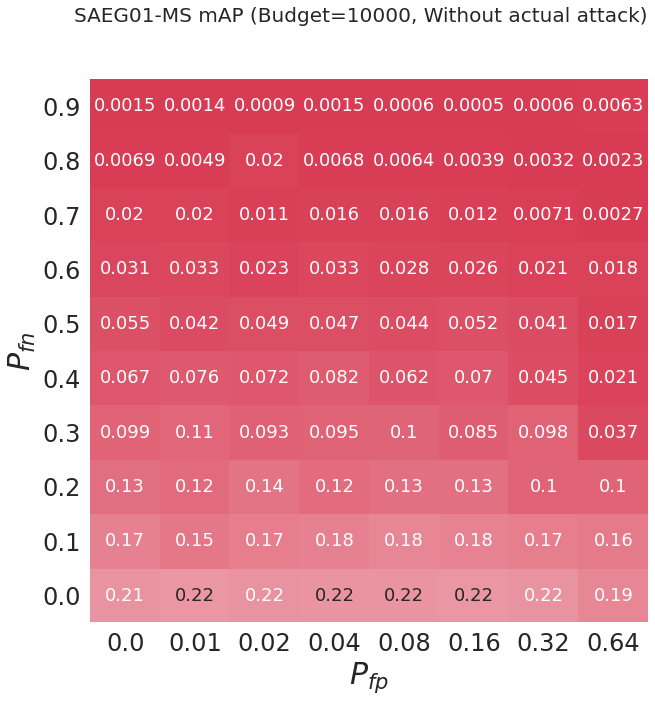

In [205]:
import seaborn as sns
import matplotlib.pyplot as plt

df = without_saeg01msdf
df = df.applymap(lambda x: round(x,4))

sns.set(font_scale=1.1)
fig = plt.figure(figsize=(10,10))

cmap_rg = sns.diverging_palette(7, 128, as_cmap=True)
res = sns.heatmap(df,annot=True, cmap=cmap_rg, 
                  cbar=False, vmin=0, vmax=0.9, annot_kws={"size":18})

res.set_xticklabels(res.get_xmajorticklabels(), fontsize=24)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=24)
res.set_yticklabels(res.get_yticklabels(), rotation=0)


plt.suptitle("SAEG01-MS mAP (Budget=10000, Without actual attack)", fontsize=20)
plt.xlabel(r'$P_{fp}$', fontsize=30, fontweight="bold")
plt.ylabel(r'$P_{fn}$', fontsize=30,fontweight="bold")
res.invert_yaxis()
# plt.tight_layout()

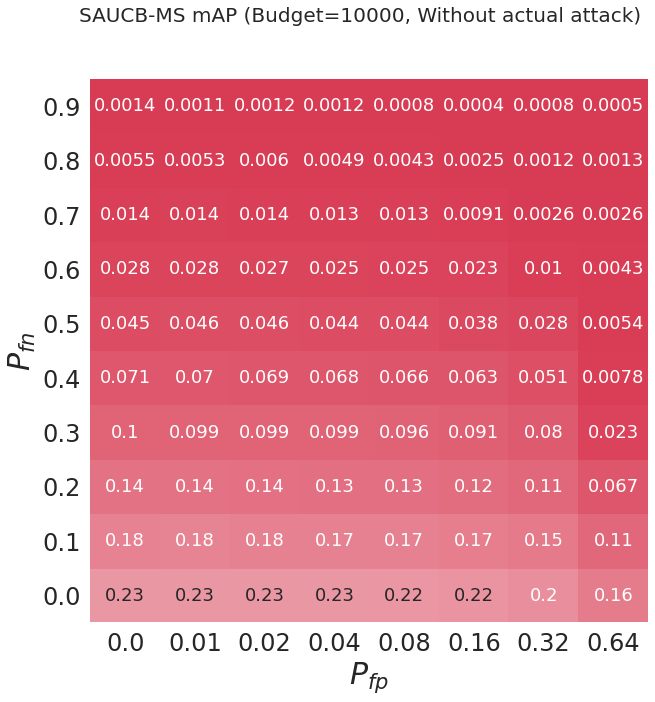

In [206]:
import seaborn as sns
import matplotlib.pyplot as plt

df = without_saucbmsdf
df = df.applymap(lambda x: round(x,4))

sns.set(font_scale=1.1)
fig = plt.figure(figsize=(10,10))

cmap_rg = sns.diverging_palette(7, 128, as_cmap=True)
res = sns.heatmap(df,annot=True, cmap=cmap_rg, 
                  cbar=False, vmin=0, vmax=0.9, annot_kws={"size":18})

res.set_xticklabels(res.get_xmajorticklabels(), fontsize=24)
res.set_yticklabels(res.get_ymajorticklabels(), fontsize=24)
res.set_yticklabels(res.get_yticklabels(), rotation=0)


plt.suptitle("SAUCB-MS mAP (Budget=10000, Without actual attack)", fontsize=20)
plt.xlabel(r'$P_{fp}$', fontsize=30, fontweight="bold")
plt.ylabel(r'$P_{fn}$', fontsize=30,fontweight="bold")
res.invert_yaxis()
# plt.tight_layout()

In [241]:
plot_mAP_policies(with_results_tuple, title="mAP as function of Pfp (With attack,Pfn={})", fp=None, fn=0.1)

<module 'matplotlib.pyplot' from '/home/liad/miniconda3/envs/jnotebook/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [242]:
plot_mAP_policies(with_results_tuple, title="mAP as function of Pfn (With attack, Pfp={})", fp=0.01, fn=None)

<module 'matplotlib.pyplot' from '/home/liad/miniconda3/envs/jnotebook/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [243]:
plot_mAP_policies(without_results_tuple, title="mAP as function of Pfp (Without attack,Pfn={})", fp=None, fn=0.1)

<module 'matplotlib.pyplot' from '/home/liad/miniconda3/envs/jnotebook/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [7]:
plot_mAP_policies(without_results_tuple, title="mAP as function of Pfpn (Without attack,Pfp={})", fp=0.01, fn=None)

<module 'matplotlib.pyplot' from '/home/liad/miniconda3/envs/jnotebook/lib/python3.7/site-packages/matplotlib/pyplot.py'>